In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import RobustScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
import pickle
import scipy.stats as spstats
%matplotlib inline


#read data 
data = pd.read_csv('dataset_test.csv')
#it contains 3 columns 
#nl_email : Newsletter ID 
#id : user ID / the follower 
#gender : the gender of the follower

#each row present a subscription
#user can have many subcriptions (followings list) 
#each newsletter can be followed by many users (followers list)


#PS : by followings i mean Subscriptions

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


''' **First step is to extract some usefull features** '''
  
we want to know how many female and male are following each newsletter 
and to extract the pourcentage of being a female type or male type newsletter 


In [4]:

#work with data a copy
df = data.copy()

#to get number of followed newsletter by each USER id 
df1 = df.groupby('id').count()
df1 =df1.rename(columns={'nl_email':'nb_followings'})
del df1['gender']


#to get number of followings for each NEWSLETTER id
df2 = df.groupby('nl_email').count()  
df2 =df2.rename(columns={'id':'nb_followers'})
del df2['gender']

#to get number of females that are following each NEWSLETTER 
df_female = df[df['gender'] == 'female']
df3 = df_female.groupby('nl_email').count() 
df3 = df3.rename(columns={'id':'nl_female_count'})
del df3['gender']


#to get number of males that are following each NEWSLETTER 
df_male = df[df['gender'] == 'male']
df4 = df_male.groupby('nl_email').count()
df4 = df4.rename(columns={'id':'nl_male_count'})
del df4['gender']


#concatenate df3 and df4 and put it in df5
df5 = pd.concat([df3, df4], axis=1, sort=False)
df5 = df5.fillna(0)

#get the pourcentage of female followers for each NEWSLETTER
df5['nl_female_pourcentage']= df5['nl_female_count'] / (df5['nl_female_count']+df5['nl_male_count'])
#get the pourcentage of male followers for each NEWSLETTER
df5['nl_male_pourcentage']= df5['nl_male_count'] / (df5['nl_female_count']+df5['nl_male_count'])


#merge all new features with the original df 
df = df.merge(df1, on='id')
df = df.merge(df2, on='nl_email')
df = df.merge(df5,on='nl_email')
df.head(50)

,nl_email,id,gender,nb_followings,nb_followers,nl_female_count,nl_male_count,nl_female_pourcentage,nl_male_pourcentage
0,0,63150,male,36,5,0.0,5.0,0.000000,1.000000
1,0,177765,male,137,5,0.0,5.0,0.000000,1.000000
2,0,289118,male,180,5,0.0,5.0,0.000000,1.000000
3,0,306212,male,590,5,0.0,5.0,0.000000,1.000000
4,0,822940,male,7,5,0.0,5.0,0.000000,1.000000
5,62788,63150,male,36,2,1.0,1.0,0.500000,0.500000
6,62788,591052,female,301,2,1.0,1.0,0.500000,0.500000
7,89982,63150,male,36,3190,2462.0,728.0,0.771787,0.228213
8,89982,44429,female,636,3190,2462.0,728.0,0.771787,0.228213
9,89982,339463,female,966,3190,2462.0,728.0,0.771787,0.228213


In [0]:
#drop id user id and email id because they givn't any important information and to avoid overfitting  problem
df_copy = df.copy()
del df['nl_email']
del df['id']

''' **Second step is to do some Exploratory Data Analysis** '''


1.   we want to plot the distribution of different features
2.   understand the CORRELATION among features 



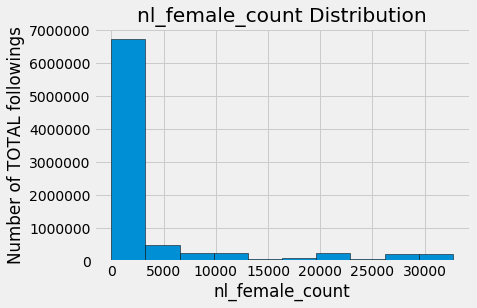

In [6]:
# Histogram of nl_female_count
plt.style.use('fivethirtyeight')
plt.hist(df['nl_female_count'].dropna(), bins = 10, edgecolor = 'k');
plt.xlabel('nl_female_count'); plt.ylabel('Number of TOTAL followings'); 
plt.title('nl_female_count Distribution');

#that shows us that for the majority of newsletter followings are less than 2500 females  

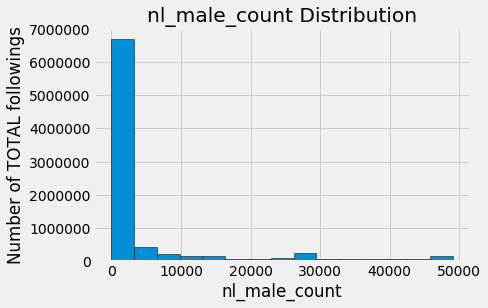

In [7]:
# Histogram of the nl_male_count
plt.style.use('fivethirtyeight')
plt.hist(df['nl_male_count'].dropna(), bins = 15, edgecolor = 'k');
plt.xlabel('nl_male_count'); plt.ylabel('Number of TOTAL followings'); 
plt.title('nl_male_count Distribution');

#that shows us that for the majority of newsletter followings are less than 2500 males 

Text(0.5, 1.0, 'Bar plot for gender')

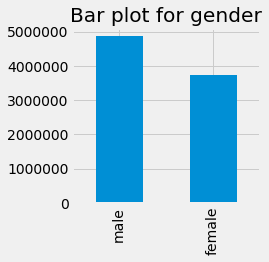

In [8]:
fig = plt.figure(figsize=(3,3)) # define plot area
ax = fig.gca() # define axis  
counts = df['gender'].value_counts() # find the counts for each unique category
counts.plot.bar(ax = ax) # Use the plot.bar method on the counts data frame
ax.set_title('Bar plot for gender')
    
#that means that the amount of male followers are more than the female followers

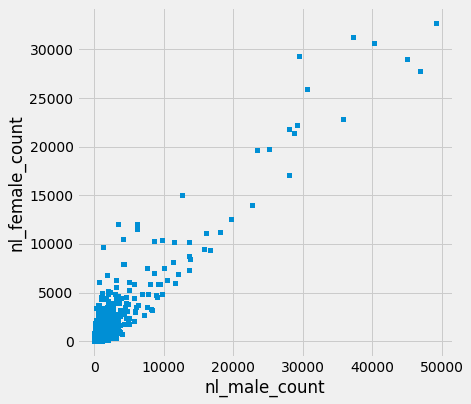

In [9]:
fig = plt.figure(figsize=(6,6)) # define plot area
ax = fig.gca() # define axis  
df.plot.scatter(x = 'nl_male_count', y = 'nl_female_count', ax = ax)

#we can understand that the more we have female followers the more we can have male followers but female followers number are relatively less than male followers 
#we will need to extract categorical feature that shows us the the amount of female/male followers (small , medium, or big number)

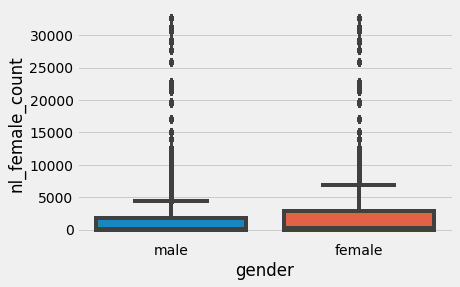

In [10]:
sns.boxplot('gender', 'nl_female_count', data=df)
plt.xlabel('gender') # Set text for the x axis
plt.ylabel('nl_female_count')# Set text for y axis
plt.show()

#we can understand that with less than 3000 and more that 2500 female followers we will have USER GENDER = female 
#with less than 2500 female followers we can have USER GENDER = male or female

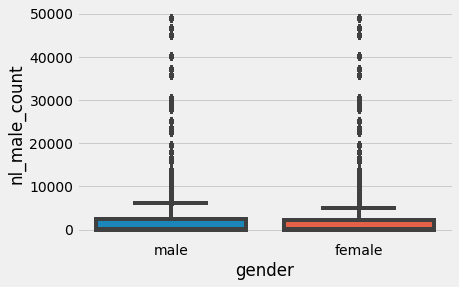

In [11]:
sns.boxplot('gender', 'nl_male_count', data=df)
plt.xlabel('gender') # Set text for the x axis
plt.ylabel('nl_male_count')# Set text for y axis
plt.show()

#we can understand that with less than 2500 male followers we can have USER GENDER = female or female

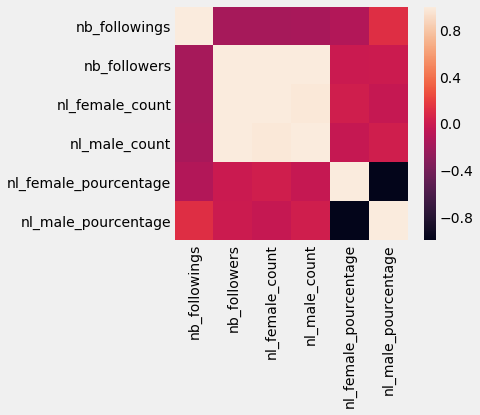

In [12]:
#CORRELATION MATRIX AMONG FEATURES
corrmat = df.corr()
f,ax = plt.subplots(figsize=(5,4))
sns.heatmap(corrmat, square=True)


#the more we have followers for each newsletter , the more we have female followers
#the more we have followers for each newsletter , the more we have male followers
#the more we have female followers for each newsletter , the more we have male followers
#the less we have male type pourcentage the more the we have female type pourcentage


'' **Third step is Feature Engineering**''

we start with numeric features

Text(0, 0.5, 'Frequency')

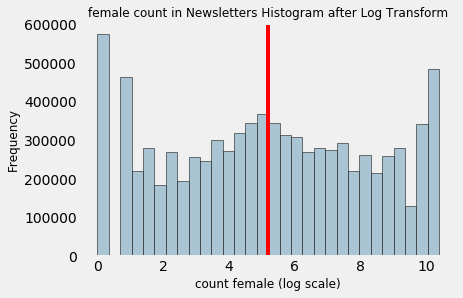

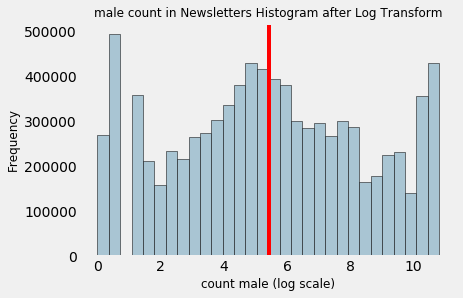

In [13]:
#Log transform

#as we could see with Data Visualization , the distribution of nl_female_count is asymetric 
# That help in stabilizing variance, adhering closely to the normal distribution and making the data independent of the mean based on its distribution

df['count_female_log'] = np.log((1+ df['nl_female_count'])) 

count_female_log_mean = np.round(np.mean(df['count_female_log']), 2)
fig, ax = plt.subplots()
df['count_female_log'].hist(bins=30, color='#A9C5D3', 
                                 edgecolor='black', grid=False)
plt.axvline(count_female_log_mean, color='r')
ax.set_title('female count in Newsletters Histogram after Log Transform', 
             fontsize=12)
ax.set_xlabel('count female (log scale)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)


df['count_male_log'] = np.log((1+ df['nl_male_count'])) 
count_male_log_mean = np.round(np.mean(df['count_male_log']), 2)
fig, ax = plt.subplots()
df['count_male_log'].hist(bins=30, color='#A9C5D3', 
                                 edgecolor='black', grid=False)
plt.axvline(count_male_log_mean, color='r')
ax.set_title('male count in Newsletters Histogram after Log Transform', 
             fontsize=12)
ax.set_xlabel('count male (log scale)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [14]:
#binarization

#if the newsletter was followed by only male users so we consider it Male type 
#elif the newsletter was followed by only female users so we consider it Female type
#else its both female and male type

bn = Binarizer(threshold=0.9)
nl_female = bn.transform([df['nl_female_count']])[0]
df['female_type'] = nl_female

nl_male = bn.transform([df['nl_male_count']])[0]
df['male_type'] = nl_male
df

,gender,nb_followings,nb_followers,nl_female_count,nl_male_count,nl_female_pourcentage,nl_male_pourcentage,count_female_log,count_male_log,female_type,male_type
0,male,36,5,0.0,5.0,0.000000,1.000000,0.000000,1.791759,0.0,1.0
1,male,137,5,0.0,5.0,0.000000,1.000000,0.000000,1.791759,0.0,1.0
2,male,180,5,0.0,5.0,0.000000,1.000000,0.000000,1.791759,0.0,1.0
3,male,590,5,0.0,5.0,0.000000,1.000000,0.000000,1.791759,0.0,1.0
4,male,7,5,0.0,5.0,0.000000,1.000000,0.000000,1.791759,0.0,1.0
5,male,36,2,1.0,1.0,0.500000,0.500000,0.693147,0.693147,1.0,1.0
6,female,301,2,1.0,1.0,0.500000,0.500000,0.693147,0.693147,1.0,1.0
7,male,36,3190,2462.0,728.0,0.771787,0.228213,7.809135,6.591674,1.0,1.0
8,female,636,3190,2462.0,728.0,0.771787,0.228213,7.809135,6.591674,1.0,1.0
9,female,966,3190,2462.0,728.0,0.771787,0.228213,7.809135,6.591674,1.0,1.0


Feature engineering for categorical features

Text(0, 0.5, 'Frequency')

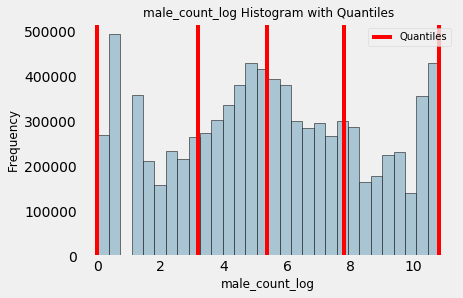

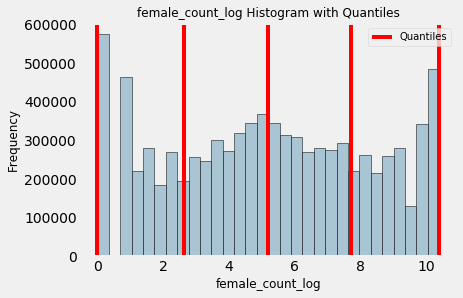

In [15]:
#Adaptive Binning  for nl_male_count

#we want to have 4 bins , each bin represent the amount of male followers

quantile_list = [0, .25, .5, .75, 1.]
quantiles_male_log = df['count_male_log'].quantile(quantile_list) 
quantile_labels = ['0-25Q', '25-50Q', '50-75Q', '75-100Q']
df['nl_male_count_quantile_range'] = pd.qcut(
                                            df['count_male_log'], 
                                            q=quantile_list)
df['nl_male_count_quantile_label_log'] = pd.qcut(
                                            df['count_male_log'], 
                                            q=quantile_list,       
                                            labels=quantile_labels)

fig, ax = plt.subplots()
df['count_male_log'].hist(bins=30,color='#A9C5D3', 
                             edgecolor='black', grid=False)
for quantile in quantiles_male_log:
    qvl = plt.axvline(quantile, color='r')
ax.legend([qvl], ['Quantiles'], fontsize=10)
ax.set_title('male_count_log Histogram with Quantiles', 
             fontsize=12)
ax.set_xlabel('male_count_log', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)


#Adaptive Binning  for nl_female_count
#we want to have 4 bins , each bin represent the amount of female followers


quantile_list = [0, .25, .5, .75, 1.]
quantiles_female_log = df['count_female_log'].quantile(quantile_list) 
quantile_labels = ['0-25Q', '25-50Q', '50-75Q', '75-100Q']
df['nl_female_count_quantile_range'] = pd.qcut(
                                            df['count_female_log'], 
                                            q=quantile_list)
df['nl_female_count_quantile_label_log'] = pd.qcut(
                                            df['count_female_log'], 
                                            q=quantile_list,       
                                            labels=quantile_labels)

fig, ax = plt.subplots()
df['count_female_log'].hist(bins=30,color='#A9C5D3', 
                             edgecolor='black', grid=False)
for quantile in quantiles_female_log:
    qvl = plt.axvline(quantile, color='r')
ax.legend([qvl], ['Quantiles'], fontsize=10)
ax.set_title('female_count_log Histogram with Quantiles', 
             fontsize=12)
ax.set_xlabel('female_count_log', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)


In [0]:
#rouding 
#we want to round the pourcentage of being a male/female type newsletter 

df['nl_female_pourcentage_scaled'] = np.array(
                  np.round((df['nl_female_pourcentage'] * 100)),    
                  dtype='int')
df['nl_male_pourcentage_scaled'] = np.array(
                   np.round((df['nl_male_pourcentage'] * 100)),  
                   dtype='int')

In [17]:
dataframe = df[['nl_female_count_quantile_label_log', 'nl_male_count_quantile_label_log','female_type','male_type' 
               ,'nl_female_pourcentage_scaled','nl_male_pourcentage_scaled','nb_followings','nb_followers','gender']]
dataframe

,nl_female_count_quantile_label_log,nl_male_count_quantile_label_log,female_type,male_type,nl_female_pourcentage_scaled,nl_male_pourcentage_scaled,nb_followings,nb_followers,gender
0,0-25Q,0-25Q,0.0,1.0,0,100,36,5,male
1,0-25Q,0-25Q,0.0,1.0,0,100,137,5,male
2,0-25Q,0-25Q,0.0,1.0,0,100,180,5,male
3,0-25Q,0-25Q,0.0,1.0,0,100,590,5,male
4,0-25Q,0-25Q,0.0,1.0,0,100,7,5,male
5,0-25Q,0-25Q,1.0,1.0,50,50,36,2,male
6,0-25Q,0-25Q,1.0,1.0,50,50,301,2,female
7,75-100Q,50-75Q,1.0,1.0,77,23,36,3190,male
8,75-100Q,50-75Q,1.0,1.0,77,23,636,3190,female
9,75-100Q,50-75Q,1.0,1.0,77,23,966,3190,female


In [18]:
#label encoding 
#we will treat this classification problem as Binary classification , so we will label encode the Target class



#Creating the dependent variable class
factor = pd.factorize(dataframe['gender'])
dataframe.gender = factor[0]
definitions = factor[1]

# transform and map nl_female_count_quantile_label_log
fem_le = LabelEncoder()
fem_labels = fem_le.fit_transform(dataframe['nl_female_count_quantile_label_log'])
dataframe['female_count_Label'] = fem_labels
# transform and map nl_male_count_quantile_label_log
male_le = LabelEncoder()
male_labels = male_le.fit_transform(dataframe['nl_male_count_quantile_label_log'])
dataframe['male_count_Label'] = male_labels



/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexi

In [19]:
#One hot encoder
#we can use One hot encoder with our nominal categorical features since the unique categories are small 


male_ohe = OneHotEncoder()
nl_male_count_feature_arr = male_ohe.fit_transform(
                                dataframe[['male_count_Label']]).toarray()
nl_male_count_feature_labels = ['male_count_Label'+str(cls_label) 
                           for cls_label in male_le.classes_]
nl_male_count_features = pd.DataFrame(nl_male_count_feature_arr, 
                            columns=nl_male_count_feature_labels)

female_ohe = OneHotEncoder()
nl_female_count_feature_arr = female_ohe.fit_transform(
                                dataframe[['female_count_Label']]).toarray()
nl_female_count_feature_labels = ['female_count_Label'+str(cls_label) 
                           for cls_label in fem_le.classes_]
nl_female_count_features = pd.DataFrame(nl_female_count_feature_arr, 
                            columns=nl_female_count_feature_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

In [20]:
df_feautures = dataframe[['gender','female_type','male_type' 
               ,'nl_female_pourcentage_scaled','nl_male_pourcentage_scaled','nb_followings','nb_followers']]
dataframe_encoded = pd.concat([df_feautures,nl_male_count_features ,nl_female_count_features], axis=1)
dataframe_encoded

,gender,female_type,male_type,nl_female_pourcentage_scaled,nl_male_pourcentage_scaled,nb_followings,nb_followers,male_count_Label0-25Q,male_count_Label25-50Q,male_count_Label50-75Q,male_count_Label75-100Q,female_count_Label0-25Q,female_count_Label25-50Q,female_count_Label50-75Q,female_count_Label75-100Q
0,0,0.0,1.0,0,100,36,5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,0.0,1.0,0,100,137,5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,0.0,1.0,0,100,180,5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0,0.0,1.0,0,100,590,5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,0.0,1.0,0,100,7,5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0,1.0,1.0,50,50,36,2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,1,1.0,1.0,50,50,301,2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0,1.0,1.0,77,23,36,3190,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
8,1,1.0,1.0,77,23,636,3190,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
9,1,1.0,1.0,77,23,966,3190,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [0]:
#save the target value
y_target = dataframe_encoded[dataframe_encoded.columns[:1]]
dataframe_encoded.drop(['gender'], axis=1, inplace=True)


'''**Split our data into TRAIN and TEST sets**'''


In [22]:
X_train, X_test, y_train, y_test = train_test_split(dataframe_encoded, y_target, test_size = 0.3)

print("Training data is", X_train.shape)
print("Training target is", y_train.shape)
print("test data is", X_test.shape)
print("test target is", y_test.shape)


Training data is (6009173, 14)
Training target is (6009173, 1)
test data is (2575361, 14)
test target is (2575361, 1)


'''**Perform feature normalization/standardization**'''

Scaling is necessary because features are measured in different units, and cover different ranges. 
so we will rescale our data, so that the variations present in our data will not affect the accuracy of model.


In [23]:
scaler = RobustScaler() 

scaler.fit(X_train)  

#Perform the transformation on train and test data
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test)

X_train

array([[ 0.  ,  0.  ,  0.96, ...,  1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -1.32, ...,  1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -0.16, ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.  ,  0.  ,  0.48, ...,  0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.2 , ...,  0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  , -1.04, ...,  0.  ,  0.  ,  0.  ]])

"**Modeling**"

Modelling in machine learning is an iterative phase where a data scientist continually train and test
machine learning models to discover the best and high performing model

we will use Naive Bayes , Random Forest , KNeighbors Classifier 
and see which of those classifier give the highest score

In [24]:
#Gaussian Naive Bayes

def GaussianNBClassifier(X_train, y_train,y_test,X_test):
  
    gnb = GaussianNB()

    # Train our classifier
    model = gnb.fit(X_train, y_train)

    # Make predictions
    y_pred = gnb.predict(X_test)
    print(y_pred)


    # Evaluate accuracy
    print("accuracy score  %f"%accuracy_score(y_test, y_pred))
    print ("confusion matrix")
    print(confusion_matrix(y_test, y_pred))
    print("classification report")
    print(classification_report(y_test, y_pred))
  
  
    #save model as pkl
    joblib.dump(model, 'gaussianNB.pkl') 
  
    return model



#KNeighborsClassifier

def KNClassifier(X_train, y_train,y_test,X_test):
    modelKN = KNeighborsClassifier(n_neighbors=3)
    # Train our classifier
    modelKN.fit(X_train, y_train)
    # Make predictions
    y_pred = modelKN.predict(X_test) 

    # Evaluate accuracy
    print("accuracy score  %f"%accuracy_score(y_test, y_pred))
    print ("confusion matrix")
    print(confusion_matrix(y_test, y_pred))
    print("classification report")
    print(classification_report(y_test, y_pred))
  
  
    #save model as pkl
    joblib.dump(modelKN, 'classifierKN.pkl')
  
    return modelKN
  




#Random Forest Classification 


def RandomFClassifier(X_train, y_train,y_test,X_test):
  
    classifierRF = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
    # Train our classifier
    classifierRF.fit(X_train, y_train)
    # Predicting the Test set results
    y_pred = classifierRF.predict(X_test)
  
    # Evaluate accuracy
    print("accuracy score  %f"%accuracy_score(y_test, y_pred))
    print ("confusion matrix")
    print(confusion_matrix(y_test, y_pred))
    print("classification report")
    print(classification_report(y_test, y_pred))
  
    #Important features
    feat_importances = pd.Series(classifierRF.feature_importances_, index=dataframe_encoded.columns)
    feat_importances.nlargest(10).plot(kind='barh')

  
    #save model as pkl
    joblib.dump(classifierRF, 'randomforestmodel.pkl') 
  
    return classifierRF
  


"loaded_model = pickle.load(open('randomforestmodel.pkl', 'rb'))\nresult = loaded_model.score(X_test, Y_test)\n"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


accuracy score  0.657421
confusion matrix
[[1102949  356232]
 [ 526032  590148]]
classification report
              precision    recall  f1-score   support

           0       0.68      0.76      0.71   1459181
           1       0.62      0.53      0.57   1116180

    accuracy                           0.66   2575361
   macro avg       0.65      0.64      0.64   2575361
weighted avg       0.65      0.66      0.65   2575361



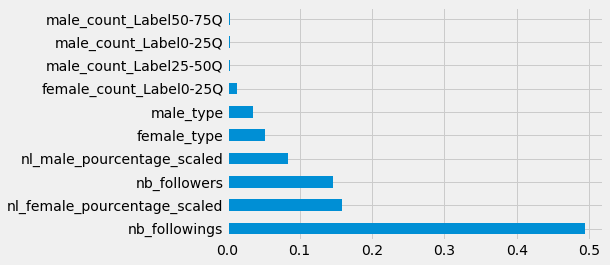

In [25]:
modelRF = RandomFClassifier(X_train, y_train,y_test,X_test)

In [26]:
modelNB = GaussianNBClassifier(X_train, y_train,y_test,X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1 1 0 ... 1 1 0]
accuracy score  0.670511
confusion matrix
[[959629 499552]
 [349001 767179]]
classification report
              precision    recall  f1-score   support

           0       0.73      0.66      0.69   1459181
           1       0.61      0.69      0.64   1116180

    accuracy                           0.67   2575361
   macro avg       0.67      0.67      0.67   2575361
weighted avg       0.68      0.67      0.67   2575361



In [0]:
# I wanted to try training with KNClassifier but that occured a runtime error , that took a lot of time traing 
#modelKN = KNClassifier(X_train, y_train,y_test,X_test)


We could use **GridSearchCV** to search over specified parameter values for an estimator



In [0]:

'''# Set the parameters by cross-validation
tuned_parameters = [{'weights': ['uniform', 'distance'],'n_neighbors': range(2,60)}]
clf = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='precision_weighted')
clf.fit(X_train, y_train)
print ("Best parameters set found on development set:\n")
print (clf.best_params_)

print ("Grid scores on development set:\n")
for params, mean_score, scores in clf.grid_scores_:
  print ("%0.3f (+/-%0.03f) for %r\n" % (mean_score, scores.std() * 2, params))

print ("Detailed classification report:\n")
y_true, y_pred = y_test, clf.predict(X_test)
print (classification_report(y_true, y_pred)) '''


'''
# Set the parameters by cross-validation
tuned_parameters = [{'max_depth': range(20,60),'n_estimators': range(10,40),'max_features': ['sqrt', 'log2', None]}]

clf = GridSearchCV(RandomForestClassifier(n_estimators=30), tuned_parameters, cv=5, scoring='precision_weighted')
clf.fit(X_train, self.y_train)
print ("Best parameters set found on development set:\n")
print (clf.best_params_)
print ("Grid scores on development set:\n")
for params, mean_score, scores in clf.grid_scores_:
  print ("%0.3f (+/-%0.03f) for %r\n" % (mean_score, scores.std() * 2, params))

print ("Detailed classification report:\n")
y_true, y_pred = self.y_test, clf.predict(self.X_test)
print (classification_report(y_true, y_pred) )
'''


'''# Set the parameters by cross-validation
tuned_parameters = [{'max_depth': range(2,60),'max_features': ['sqrt', 'log2', None]}]
clf = GridSearchCV(DecisionTreeClassifier(max_depth=5), tuned_parameters, cv=5, scoring='precision_weighted')
clf.fit(X_train, y_train)

print ("Best parameters set found on development set:\n")
print (clf.best_params_)
print ("Grid scores on development set:\n")
for params, mean_score, scores in clf.grid_scores_:
  print ("%0.3f (+/-%0.03f) for %r\n" % (mean_score, scores.std() * 2, params))
print ("Detailed classification report:\n")
y_true, y_pred = y_test, clf.predict(X_test)
print (classification_report(y_true, y_pred) )
'''

Now we will use the model that gives us the highest accuracy score which is NAIVE BAYES and predict the gender of a user who has followed a certain number of Newsletters 


INPUT : list of newsletters ID 

OUTPUT : the gender 

In [29]:
def predictGender(list_nl_id , model):
    female_gender=0
    male_gender=0

    #for each newsletter ID we extract the row that present the correspondant Data 
    #we use our model to predict the gender 
    #for each newsletter the model predict a gender , so we will get the pourcentage of being a female or male 

    for i in range(len(list_nl_id)):
        Index_label = df_copy.index[df_copy['nl_email'] == int(list_nl_id[i])].tolist()
        newsletter = dataframe_encoded.loc[ Index_label[0] , : ]
        x_random = [[newsletter['female_type'] ,  newsletter['male_type'] , newsletter['nl_female_pourcentage_scaled'] , newsletter['nl_male_pourcentage_scaled'] ,len(list_nl_id),newsletter['nb_followers'] ,
              newsletter['male_count_Label0-25Q'] ,newsletter['male_count_Label25-50Q'] ,newsletter['male_count_Label50-75Q'] ,newsletter['male_count_Label75-100Q'] ,newsletter['female_count_Label0-25Q'],
              newsletter['female_count_Label25-50Q'],newsletter['female_count_Label50-75Q'], newsletter['female_count_Label75-100Q'] ]]
        y_random=(model.predict(x_random))
        print(y_random)
        
        reversefactor = dict(zip(range(2),definitions))
        g =np.vectorize(reversefactor.get)(0)
  
        if g.item(0) == 'female':
            female_gender+=1
        else:
            male_gender+=1
        print(g.item(0))
    
    pourcentage_female = female_gender/(female_gender+male_gender)*100
    pourcentage_male = male_gender/(female_gender+male_gender)*100
  
    print("female gender : %0.2f%%  & male gender : %0.2f%%"%(pourcentage_female,pourcentage_male))


    
'''
#load  models
loaded_modelNB = pickle.load(open('gaussianNB.pkl', 'rb'))
loaded_modelRF = pickle.load(open('randomforestmodel.pkl', 'rb'))
'''

#we give a list of newsletter ID that a user followed 
list_nl_id = ['62788','0','89982','181834']


print("using Naive Bayes Model")
predictGender(list_nl_id,modelNB)

print("using Random Forest Model")
predictGender(list_nl_id,modelRF)

#print("using Kneighbors Model")
#predictGender(list_nl_id,loaded_modelKN)




using Naive Bayes Model
[1]
male
[1]
male
[0]
male
[1]
male
female gender : 0.00%  & male gender : 100.00%
using Random Forest Model
[0]
male
[0]
male
[0]
male
[0]
male
female gender : 0.00%  & male gender : 100.00%
